In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from lmfit.models import VoigtModel,PseudoVoigtModel, LinearModel
from scipy import stats
from scipy.signal import savgol_filter
plt.rcParams["figure.figsize"] = (20,10)


def multi():
    E=210000
    v=0.3
    theta2=156
    theta2/=2
    V=2.0*(1.0+v)
    theta = np.radians(theta2)
    theta = np.tan(theta)
    theta = 1.0/theta
    theta *= (np.pi/180.0)
    theta *=E
    theta /=-1.0*V
    ##    return theta/9.8#kg
    return theta#Mpa

#return novot
def removekalpha(y,x):
    novoy=[]
    lambida2=1.541220
    lambida1=1.537400
    deltaL = lambida2 - lambida1
    deltaL = deltaL/lambida1
    diferenca=x[1]-x[0]

    for i in range(len(y)):
        deltasoma = x[1]-x[0]
        ase= np.tan(np.radians(x[i]/2))*2*deltaL/(diferenca)
        n=1;

        while(ase>deltasoma):
            deltasoma=deltasoma+diferenca
            n+=1
        try:
            yy=y[i]-0.5*y[i-n]

            if yy<0:yy=(yy+y[i])/8

            novoy.append(yy)
        except:
            novoy.append(y[i])

    return novoy

#return y
def background(y):
    minimo=min(y)
    for i in range(len(y)):
        y[i]-=minimo
    return y

#return y
def normalizar(y):
    minimo=max(y)
    for i in range(len(y)):
        y[i]/=minimo
    return y

def removerzero(vetor):
    for key, value in enumerate(vetor):
        if value <0:
            vetor[key]=0

    for key,value in enumerate(vetor):
        try:
            if vetor[key+1]==0 and value >0:
                vetor[key]=0
        except:
            pass
    return vetor

def read_file(file_name):
    psi=0
    r = open(file_name,'r')
    printar = False
    vx = []
    vy = []
    for i in r:
        if printar:
            value = i.split(' ')
            x=value[3]
            x = float(x)
            vx.append(x)
            y=value[-1].split('\n')[0]
            y =float(y)
            vy.append(y)
        if not printar and '<2Theta>   <   I   >' in i:
            printar = True
        if not printar and 'psi angle' in i:
            value = i.split(' ')
            psi=float(value[-3])
            psi=np.sin(np.radians(psi))**2

    vx = np.asarray(vx)
    vy = np.asarray(vy)
    return psi, vx, vy

def removerbackground(x,y,m=5):

    minimo= np.mean( np.sort(y)[:10])
    for i in range(len(y)):
        y[i]=y[i]-minimo
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.append(x[:m],x[-m:]),np.append(y[:m],y[-m:]))
    abline_values = [slope * i + intercept for i in x]
    abline_values=np.asarray(abline_values)
    return removerzero(y-abline_values)


def processing_of_data(x,y):
    y = normalizar(y)
    y = background(y)
    y = removerbackground(x,y)
    #y = removekalpha(x,y)
    #pdb.set_trace()
    y = savgol_filter(y, 5, 2)
    
    y = normalizar(y)

    return x,y

def center_psi(file_name):
    psi, vx, vy = read_file(file_name)
    vx, vy = processing_of_data(vx,vy)
    legenda = file_name.split('/')[-1]
    plt.grid()
    plt.legend(loc=0)
    plt.plot(vx,vy,label=legenda)
    mod = PseudoVoigtModel()
    y=vy
    pars = mod.guess(y, x=vx)
    out  = mod.fit(y, pars, x=vx)
    center =out.best_values['center']
    return psi, center

def lenar_calc(x,y):
    mod = LinearModel()
    pars = mod.guess(y, x=x)
    out  = mod.fit(y, pars, x=x)
    calc= out.best_values['slope']
    stress=calc*multi()
    stress=round(stress,3)
    #plt.plot(x,out.bes_fit)
    return stress, x , out.best_fit
    #print(out.best_values)

No handles with labels found to put in legend.


Start


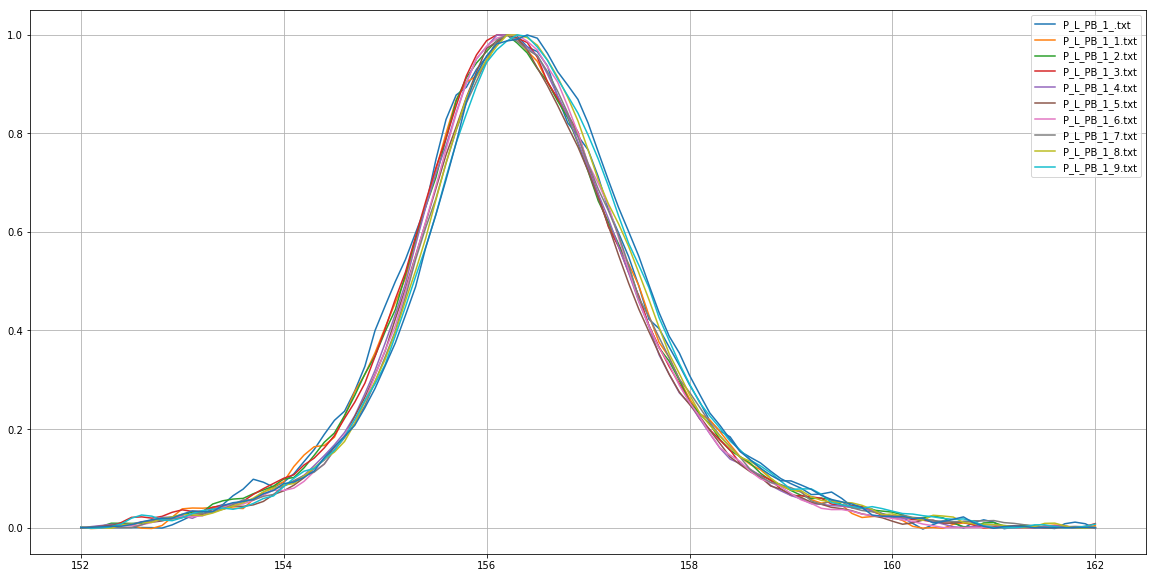

In [4]:
center_list =[]
psi_list =[]

print('Start')

dados='P_L_PB_1'

file_names=[]
file_names.append('P_L_/P_L_PB_1_/P_L_PB_1_.txt')

for i in range(1,11):
    file_name='P_L_/{}_{}/{}_{}.txt'.format(dados,str(i),dados,str(i))
    file_names.append(file_name)

#for file_name in file_names:
#    print(file_name)
#pdb.set_trace()

for file_name in file_names:
    psi, center = center_psi(file_name)
    psi_list.append(psi)
    center_list.append(center)
plt.show()

In [ ]:
    miny=int(min(center_list))-2
    maxy=int(max(center_list))+2
    maxx=round(max(psi_list),3)+round(max(psi_list),3)/2
    plt.axis([0,maxx,miny,maxy])

    plt.grid()
    plt.title(dados)
    plt.xlabel('$\sin ^{2}\omega (Mpa)$')
    plt.ylabel('$2\Theta (Degre)$')
    legenda ,x,bestY= lenar_calc(psi_list,center_list)
    #plt.legend(legenda)
    plt.plot(psi_list,center_list,'o',label=abs(legenda))
    plt.plot(x,bestY)
    plt.legend(loc=0)
    plt.show()
